Jakub Kuriata <br>
Joseph D'Angelo <br>
Sunny Atalig

# 1. The Question

Many applications, such as robotics and automated vehicles, require computers to identify objects in their environment and act appropriately. (i.e.
avoid dangers, not harm humans etc.) In this tutorial we do a warm up for
this general problem: can we build a classifier for 3D objects?

Make sure that the runtime is using a GPU to speed up the tensor computations. For google colab Runtime>Change runtime type>T4 GPU


# 2. The Data

We use the “Norb Dataset” available from TensorFlow. It contains gray-scale 96x96 pixel images of physical toys, taken by a camera with various angles and lighting setups, tagged with one of five classes (“four-legged animals”, “human figures”, “airplanes”, “trucks, “cars”). There are copies of the same object and angles taken under different lighting. Below are a few examples:

(cars)
<br>

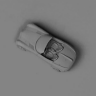 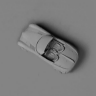

(four-legged animals)
<br>
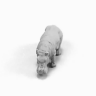 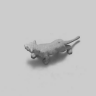

(trucks)
<br>
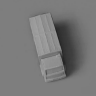 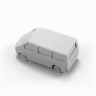

# 3. Our Approach

Since object recognition is a problem about gathering spatial information,
we will be experimenting with Convolutional Neural Networks (CNNs). For
this project, we’re also interested in learning how the method works, so we’ll
be building the network ourselves. (This will take up most of the project...)

# 4. Why Is This Important?

Image recognition is fundamental for data analysis, it can be applied to a wide variety of topics. One of the datasets we considered had iPhone images of bean leafs that was made to identify diseases in beanstalks. This implies accessibility for a problem that someone might have, as most people have access to a camera(these days) in similar quality. There are tons of applications for image recognition: security, object detection, medical imaging, just to name a few.

# 5. Basic Setup:

Here are all the libraries used in this specification. As we work in Python, we make use of torch and tensorflow, both of which are machine learning focused libraries. Tensorflow in particular will only be used for loading in the Norb dataset, while torch will be used for fast math operations. We won’t be using the built-in neural network frameworks they have, but we’ll be using stuff like matrix multiplication and convolutions. For debugging our code, we’ll import the mnist digits dataset from keras — it’s a trivial problem, so if our code fails to solve it the we know something’s wrong with our algorithm. IPython.display is to display the data in a ipynb notebook, and randint is just for randomly selecting data points for any examples. numpy and PIL/Image are here just for converting our data set (which is from tensorflow) into PyTorch tensors.

In [29]:
!pip install tensorflow

from abc import ABC, abstractmethod # we like abstract classes
import torch #we use for tensor math

from random import randint #used for inspecting random data points
from PIL import Image # used for importing data

from IPython.display import display #displaying our data points in the notebook
from PIL import Image
import matplotlib.pyplot as plt #plot out loss over epochs
import tensorflow as tf
import tensorflow_datasets as tfds #FOR IMPORTING NORB DATASET
import numpy as np #needed to converting data
import time # document runtime of our model
import math
import os # for storing/reading files

from IPython.display import HTML # to add links to this notebook

! PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True #prevent memory fragmentation and leaks

## Norb Dataset

Let's first take a quick look at the dataset. We'll be importing a small sample of the data from tensorflow - see this [link]("https://cs.nyu.edu/~yann/data/norb-v1.0/") for more info.

In [30]:

# Import data
norb_train = tfds.load('smallnorb', split='train', as_supervised=True)
norb_test = tfds.load('smallnorb', split='test', as_supervised=True)


We'll introduce the following helper function to convert the data to a PyTorch Tensor

In [31]:
# turn the tensorflow tensors into pytorch tensors
# turns the label into a zero array of length label_len, where
# the labels xth element is set to 1
# flatten will flatten the 2D image into a 1D array
def tf_to_torch(data, label_len, flatten=False):
  images = []
  labels = []
  for image, label in data:
    if(flatten):
      images.append(torch.from_numpy(image.numpy().squeeze().flatten()).type(torch.float32))
    else:
      images.append(torch.from_numpy(image.numpy().squeeze()).type(torch.float32))
    labeln = np.zeros(label_len)
    labeln[label] = 1
    labels.append(torch.from_numpy(labeln).type(torch.float32))
  return torch.stack(images), torch.stack(labels)


Before we move, let's take a quick look at the images.

In [32]:
images, labels = tf_to_torch(norb_train, 5)
norb_label_names = ['four-legged animal', 'human figure', 'airplane', 'truck', 'car']

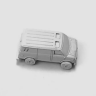

truck


In [33]:
index = randint(0, images.size()[0])

# display the image
im = Image.fromarray((images[index].numpy()).astype(np.uint8))
display(im)

# print the label
true_label = torch.argmax(labels[index])
print(norb_label_names[true_label])


# 6. A Fun Way to Derive Back-Propagation

Okay, now on to the hard part: actually building the network. The bulk of this tutorial is basically gonna be a crash course on gradient descent math, showing how we derive the formulas for each “layer”.

The bulk of the project itself is just implementing neural network framework from the ground up. There's already plenty of sources describing the basics of how back propogation works, such as this one:


In [34]:
HTML('<iframe width="300" height="200" src="https://www.youtube.com/embed/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi" title="Backpropagation, step-by-step | DL3" frameborder="0"  allowfullscreen></iframe>')

But the fun part is that we have a method to work out the formulas by hand in way that gives *automtically compact formulas* (i.e. ones that easy to implement in terms of built-in library functions such pytorch). It's not  novel, as we discovered later that there happens to be an [arxiv paper](https://arxiv.org/pdf/2209.13234) that presents similar ideas (it's also sorted related to Andrew Ng's use of matrix gradients in [CS229](https://www.youtube.com/watch?v=4b4MUYve_U8&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU&index=2), but taken to the extreme). Regardless, it's not the standard way you present gradient descent in introductory material, and it's pretty fun to learn.

Now, it's not really feasible to actually teach the method in a short tutorial - there's too many technicalities to get into. So instead we'll focus on showing what using the technique *looks like*  with an example. **The notation below is designed to be suggestive rather than technically correct, so mind the sloppiness.**

## Let's take the derivative of softmax

Here's a fan favourite in multi-class classification. The function below takes vectors to vectors

$$ \text{softmax}(x_1, \ldots, x_n) = (s_1, \ldots, s_n)$$
where
$$ s_i  = \frac{e^{x_i}}{\sum_{i=j}^{n} e^{x_j}} $$

while the function looks ugly at first, you describe it succinctly in two steps. You (1) apply the exponential function to each component of the vector then (2) scale the result of (1) so that that the entries sum to one. In short it allows you take a vector with arbitrary values and map it to a probability distribution (think of the components as representing labels/classes).

Not only is the above description useful conceptually, but it will also make the math easier. Let
$$y = e^x = (e^{x_1} , e^{x_2}, \ldots, e^{x_n}) \quad \bar{1} = (1, 1, \ldots, 1)$$
Then we can write softmax as
$$ \text{softmax} (x) = s = \frac{1}{\bar{1} \cdot y} y $$
where $\cdot$ is just the dot product. With this formula, we can "easily" take the derivative of softmax:

\begin{align*}
 s'(dx) &= \left( \frac{1}{\bar{1}\cdot y} y \right)'(dx) \\
&=  \left( \frac{1}{\bar{1} \cdot y} \right)'(dx)\, y + \frac{1}{\bar{1} \cdot y} y'(dx) &&\quad \text{(product rule)} \\
&=  \left( \frac{1}{\bar{1} \cdot y} \right)' (dx)\, y + \frac{1}{\bar{1} \cdot y} (y \odot dx) &&\quad \text{($d(e^x) = e^x dx$)} \\
&= \left( - \frac{1}{(\bar{1}\cdot y)^2} \right) (\bar{1}\cdot y)' (dx) \, y+ \frac{1}{\bar{1} \cdot y} (y \odot dx) &&\quad \text{($d(1/x) = -(1/x^2) dx$, chain rule)} \\
&= \left( - \frac{1}{(\bar{1}\cdot y)^2} \right) \left[\bar{1}\cdot y' (dx)\right] y+ \frac{1}{\bar{1} \cdot y} (y \odot dx) &&\quad d(1\cdot x)/dx = 1\\
&= \left( - \frac{1}{(\bar{1}\cdot y)^2} \right) \left[\bar{1}\cdot y \odot dx\right] y+ \frac{1}{\bar{1} \cdot y} (y \odot dx) &&\\
&= \left( - \frac{1}{(\bar{1}\cdot y)^2} \right) \left[ y \cdot dx\right] y+ \frac{1}{\bar{1} \cdot y} (y \odot dx) &&\quad 1 \cdot a = a\\
s' (dx) &= s \odot dx -(s \cdot dx) s  &&\quad \text{group $y$ terms in $s$ terms}
\end{align*}

<font color = 'red'> You don't need worry about the details here; the shape of these formulas are what's important. </font> First, let's focus on the last line --- where we have a function that takes vectors to vectors
$$L(v) = s \odot v -(s \cdot v) s$$
where $s=\text{softmax}(x)$ and $\odot$ is "component-wise multiplication", i.e. $(x_1,x_2) \odot (y_1, y_2) = (x_1 y_1, x_2 y_2)$. In a more standard treatment of multivariable calculus, the analog of "derivatives" for vector-to-vector functions is the **Jacobian** $J$ - the exact formula doesn't matter, the important bit is that it's a matrix full of partial derivatives. <font color = 'red'> The punchline is that multiplying vector $v$ by softmax's Jacobian is exactly the same as applying the function $L$. </font>

Even though the lines above are basically just gobbledygook, we hope it looks similar to something you'd see in a first year calculus class. <font color="DodgerBlue"> That's sort of the spirt of this technique: you don't have $n$ different variables, just one---the vector itself. </font>


Really, what we've just computed is called a "[Fréchet derivative]("https://en.wikipedia.org/wiki/Fr%C3%A9chet_derivative)". Taking a step back, we have a lot of derivative-like things in calculus when you have many variables

$$ f(x+dx) - f(x) \approx \begin{cases} f'(x) dx & \text{one input, one output} & \text{scalar times scalar} \\ \nabla f \cdot dx & \text{many inputs, one output} & \text{vector times vector} \\ J_f (dx) & \text{many inputs, many outputs} & \text{matrix times vector} \end{cases}$$

We unify all these cases by treating the derivative as *abstract linear functions*, such as $L$ above.

## Why do Calculus this Way?

* You get a nice chain rule and product rule this way. No need to split up into a bunch of partial derivatives.

* The "variables" you can take derivatives can look like anything. They can be 1D vectors, matrices, tensors, batches of vectors --- it doesn't matter, the Fréchet derivative works regardless.

* Most functions you see in Machine Learning involve either linear functions or "componentwise functions" (apply a function to every entry/row/block/etc). This technique works especially well with these types of functions.

* You naturally get formulas in terms of high-level operations that are supported by your favourite math library. For example, we actually use that softmax derivative formula in our code!

We're skipping a lot of technical details here (how are we supposed to get gradient vectors out of this?). A place to start learning are the links above (unfortunately only the 3b1b video is accessible for general audiences).

# 7. Code for the Neural Network

## 7.1 High Level Architecture

The basic primitive of our code is the abstract ```layer``` class. Informally, this specializes into the following types:
* neuron connections with weights (matrix multiply, convolution, etc)
* transfer functions (ReLu, Pooling, ...)
* cost functions (Euclidean Cost, Cross Entropy)

The philosophy behind the code is that we want to implement back propagation in a "dimension agnostic way". The neural network doesn't need to know what its layers look like, and layers don't need to know the internals of other layers.

The three most important function layers are ```evaluate```, ```differential```, and ```update_grad```. The first one is straightforward, you get input from the last layer and spit out the values for the next. If you've seen back propagation calculus, you've probably seen chain rule formulas like
$$ \frac{dg}{dw_i} = \frac{da_i}{dw_i} \frac{da_{i+1}}{da_i} \cdots \frac{da_{n}}{da_{n-1}} \frac{dg}{da_{n}} $$
where $a_i$ are the layer neurons and $g$ is the cost function, and $w_i$ is the weight at layer $i$. Loosely speaking, ```differential``` corresponds to the $d/da_i$'s - a layer gets a gradient-esque value from the succeeding layer and sends a value to the previous layer. Likewise ```update_grad``` corresponds to $d/dw_i$, where the gradient is actually computed.

In [35]:
#general description for layer
#can be linear maps, non-linear transfer functions, cost function
#layer takes in input and spits out stuff for next layer
#typically subclasses will have some auxilliary data

# A layers tensors exist externally on device(gpu)
# This means any tensor input should already be on device
# and every tensor output is on device
class layer(ABC):

    #evaluate layer's function on input
    #store auxilliary data for differential if needed
    @abstractmethod
    def evaluate(self, input):
        pass

    #use auxilliary to compute ''differiential'' on input delta
    @abstractmethod
    def differential(self, delta):
        pass

    #compute the gradient on delta, then add it to auxilliary grad variable
    @abstractmethod
    def update_grad(self, delta, alpha):
        pass

    #update weight with gradient (technical: if we handle batches with a loop, we want to update the weight once)
    @abstractmethod
    def update_weight(self):
        pass

    #if we have auxilliary gradient data, set it to zero (exists because of update_weight)
    @abstractmethod
    def reset_grad(self):
        pass

    # last two are self explanatory - if we have weights, we can load and store them to files
    @abstractmethod
    def store_weights(self, name):
        pass

    @abstractmethod
    def load_weights(self, name):
        pass

We also have have the ```model``` class, which is how we build the neural networks and implement the back propgation algorithm. You don't need to touch the internals here, important functions/variables to note:

* ```self.layers``` is literally just a list - you can append whatever layers classes you want here

* ```self.cost``` contains the layer for the cost function. It's separated since it's only needed for training. ```self.loss``` records actual values during the training.

* ```set_data(data, pred)``` is where you put features and labels for training.

* ```load``` and ```save``` for loading/storing weights. Examples are shown later

* ```get_acc_metrics(X,Y)``` get accuracy/sensitivity/specificity of the model for a given test set. Inputs our your features X and labels Y.

* ```train(epochs, loop, tx, ty, batch_size):``` this is how you actually train the data. We do the standard trick where we permute the training data, then do gradient descent in batches. You can add additional test data ```tx, ty``` to record accuracy over time (doesn't display full metrics). ```loop``` is depreciated.

In [36]:


#general model
#includes:
#list of layers
#cost function
#data (data variable is fed through network, pred is the value we're trying to predict)
#alpha is learning rate
#batch_size determines how large of batch we use for back-propagation

# The model acts as a communication layer between host and device,
# be careful to manage sending data from the host and receiving data from the device
class model:
    def __init__(self):
        self.layers = []
        self.cost = None
        self.data = None
        self.pred = None
        self.alpha = None
        self.batch_size = None
        self.start = time.time()
        self.loss = []

    def set_data(self, data, pred):
        self.data = data.to("cuda")
        self.pred = pred.to("cuda")

    #self explanatory, note that we don't compute cost function at end
    #RETURNS ON DEVICE TENSOR: use predict method for cpu tensor
    def feedforward(self, x):
        if not x.is_cuda:
          x = x.to("cuda")
        for layer in self.layers:
            x = layer.evaluate(x)
        return x

    def predict(self, x):
        return self.feedforward(x).to("cpu")

    #computes cost function after calling feedforward()
    #assumes x and y are on device
    def get_cost(self, x, y):
        return self.cost.evaluate((x,y))

    #updates gradients after calling get_cost() and feedforward()
    #assumes delta is on device
    def backpropagate(self, delta):
        for layer in self.layers[::-1]:
            layer.update_grad(delta, self.alpha/self.batch_size)
            delta = layer.differential(delta)

    #actually update weights with gradients
    def update_weights(self):
        for layer in self.layers:
            layer.update_weight()

    #set all gradients to 0 (we accumulate gradients for each data points, that's why we need this)
    def reset_gradients(self):
        for layer in self.layers:
            layer.reset_grad()

    #runs network on a single data point pair
    #assumes x and y are on device
    def full_pass(self, x, y):
        output = self.feedforward(x)
        cost = self.get_cost(output, y)
        delta = self.cost.differential(cost)
        self.backpropagate(delta)

    #runs network on a batch, then updates weights
    #"loop" is false when the network is designed to run on batch in a single pass (rather than processing datapoints individually)
    #assumes batch and pred are on device
    def one_step(self, loop, batch, pred):
        if(loop):
            N = batch.size()[0]
            for i in range(0, N):
                self.full_pass(batch[i], pred[i])
        else:
            self.full_pass(batch, pred)
        self.update_weights()
        self.reset_gradients()

    #returns normal accuracy - see get_acc_metrics for additional measures
    def get_accuracy(self, testX, testY):


        testX = testX.to("cuda")
        testY = testY.to("cuda")
        r = self.feedforward(testX)
        self.loss.append(self.get_cost(r, testY).tolist())

        return torch.sum(torch.argmax(r, dim=1) == torch.argmax(testY, dim=1))/testX.size()[0]

    # Takes in the testX and testY and generates a prediction. labels should hold a list [0,...,n] where n is the number of classes/labels
    # Returns a dictionary holding a count of the True Positives, True Negatives, False Positives, False Negatives, Count of Positive Predictions, Cout of Negative Predictions
    # for each class n.
    def get_acc_metrics(self, testX, testY, labels):
        testX = testX.to("cuda")
        testY = testY.to("cuda")
        r = self.feedforward(testX)
        r = torch.argmax(r, dim=1)
        y = torch.argmax(testY, dim=1)

        d = {}
        for l in labels:
            #     TP,TN,FP,FN,predpos,predneg
            d[l] = [0,0,0,0,0,0]
            for i in range(0,r.size(0)):
                if r[i] == l:
                    #TP
                    if r[i] == y[i]:
                        d[l][0] += 1
                    #FP
                    elif r[i] != y[i]:
                        d[l][2] += 1
                    #increment predicted positive
                    d[l][4] += 1
                else:
                    #FN
                    if y[i] == l:
                        d[l][3] += 1
                    #TN
                    else:
                        d[l][1] += 1
                    #increment predicted negative
                    d[l][5] += 1
        return d


    #every epoch, we randomly permute data, then run a step of gradient descent on each batch
    def train(self, epochs, loop, tx, ty, batch_size):
        tx = tx.to("cuda")
        ty = ty.to("cuda")
        self.batch_size = batch_size
        for i in range(0, epochs):
            if(i% 10 == 0):
                t = time.strftime('%H:%M:%S', time.gmtime(time.time() - self.start))
                a = round(float(self.get_accuracy(tx, ty)), 4)
                print(f"started epoch {i} at time {t} with accuracy {a}")
            pi = torch.randperm(self.data.size()[0])
            self.data = self.data[pi]
            self.pred = self.pred[pi]
            for j in range(0, self.data.size()[0]//batch_size, batch_size):
                b = self.data[j:j+batch_size]
                p = self.pred[j:j+batch_size]
                self.one_step(loop=loop,batch=b,pred=p)

    # load the data for each layer, if any fail return False
    def load(self, name):
      for i, layer in enumerate(self.layers):
        if not layer.load_weights(name + "_" + str(i)):
          print(f"failed to load layer {i}")
          return False
      print("Loaded all pretrained layers")
      return True

    # save the layers data to file
    def save(self, name):
      for i, layer in enumerate(self.layers):
        layer.store_weights(name + "_" + str(i))








## 7.2 Encyclopedia for Layers

Here is where all of the layers are actually implemented. For each one we'll note what the layer does and the expected input/outputs.

<font color='red'> You can skip this the first time around, we have examples models created for you. You shouldn't need to touch the internals either. </font>

An important detail when reading the code: everything is implemented in terms of ```PyTorch``` tensors, which are just multi-dimensional arrays. The layers are designed to take in data points in batches, and you should package your data in terms of tensors when feeding them to the model. Unfortunately, you'll also need to manually work out the dimensions for each layer.

### 7.2.1 Cost Functions

The only ones we support our euclidean cost $(x-y)^2$ and the [cross-entropy]("https://en.wikipedia.org/wiki/Cross-entropy") function (the multi-class version). Typically you feed in batches of data as a matrix. However, both functions are ``component-wise'' so the dimensions of the data doesn't actually matter.

For cross-entropy you should only feed it non-negative values (really it expects the rows to be probability distribution).

<font color="DodgerBlue"> Fun Fact: You may notice the little fudge factor 0.001 in the cross-entropy. That's there for numerical stability - don't want to divide by zero!  </font>

In [37]:
#cost is |x-y|^2
class euclidean_cost(layer):
    def __init__(self):
        self.aux = None
    def evaluate(self, input):
        x,y = input
        self.aux = x-y
        return torch.inner(self.aux, self.aux)
    def differential(self, delta):
        return self.aux
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True

#cost is cross_entropy function
class cross_entropy(layer):
    def __init__(self):
        self.aux = None
    def evaluate(self, input):
        x,y = input
        self.aux = -( torch.where(y>0.5,1/(x+0.001), 0))
        return -torch.sum( torch.where(y>0.5, torch.log(x+0.001), 0) )
    def differential(self, delta):
        return self.aux
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True



### 7.2.2 Softmax

Input should be a $(n\times c)$ array, where each row represents a data point. Unsurprisingly, runs softmax on each row of the matrix.

<font color="DodgerBlue"> Fun fact: if you look closely, you may notice this extra step involving the ```max``` function. If we run softmax on a single row, and let $M$ be the largest component in vector $x$ we can rewrite the formula as
$$ \text{softmax}(x)_i = s_i  =  \frac{e^{x_i - M} }{\sum_j e^{x_j - M}} $$
where all we're doing is just multiplying $e^{-M}$ to the numerator and denominator. This formula is useful because it guarantees that all of our $e^{x_i}$ values are in the range $(0,1)$, improving numerical stability.
 </font>


In [38]:
#rowwise softmax
class rowwise_softmax(layer):
    def __init__(self):
        self.aux = None
    def evaluate(self, input):

        if(len(input.size()) == 1):
            self.aux = input - torch.max(input)
            self.aux = torch.exp(self.aux)
            self.aux /= torch.sum(self.aux)
            return self.aux
        else:
            X, dontuse = torch.max(input,dim=1)
            self.aux = input - X.repeat(input.size()[1], 1).T
            self.aux = torch.exp(self.aux)
            x = torch.sum(self.aux, dim=1)
            self.aux /= x.repeat(self.aux.size()[1], 1).T
            return self.aux
    def differential(self, delta):
        if(len(self.aux.size())==1):
            return self.aux*delta - torch.inner(self.aux, delta)*self.aux
        return self.aux*delta - torch.sum(self.aux * delta, dim=1).repeat(self.aux.size()[1], 1).T*self.aux
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True

### 7.2.3  Simple Transfer Functions

Nothing fancy here, just ReLU and the sigmoid function. These functions are dimensionless, meaning any tensor is a valid input.

In [39]:
#computes relu function
class relu(layer):
    def __init__(self):
        self.aux = None
        self.device = torch.device("cuda")
    def evaluate(self, input):
        self.aux = input
        return torch.maximum(input, torch.zeros(input.size(), device=self.device))
    def differential(self, delta):
        return torch.greater(self.aux, torch.zeros(self.aux.size(), device=self.device))*delta
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True
#sigmoid
class sigmoid(layer):
    def __init__(self):
        self.aux = None
    def evaluate(self, input):
        self.aux = 1/(1+torch.exp(-input))
        return self.aux
    def differential(self, delta):
        return delta*(self.aux*(1-self.aux))
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True

### 7.2.4 Layers with Weights or Kernels

The most complicated layers are here. Understanding the inputs/outputs requires close attention.

In [40]:
#input is 3d array (batch of 2d images), kernel is 3d array (multiple channels of 2d kernels), bias is 2d array
class convolution_layer(layer):
    def __init__(self, input_size, kernel_size, normal_distribution=True):
        self.device = torch.device("cuda")
        self.W  = self.b  = self.a = self.gradW = self.gradB = None
        if (not normal_distribution):
          self.W = -2*torch.rand(kernel_size, device=self.device)+1
          x,y,z = kernel_size[0], kernel_size[1], kernel_size[2]
          self.b = -2*torch.rand(x, input_size[0]-y+1, input_size[1]-z+1, device=self.device)
          self.a = torch.zeros(input_size, device=self.device)
          self.gradW = torch.zeros(self.W.size(), device=self.device)
          self.gradB = torch.zeros(self.b.size(), device=self.device)
        else:
          self.W = torch.normal(mean = torch.zeros(kernel_size, device=self.device),std = torch.ones(kernel_size, device=self.device)*2/math.prod(kernel_size))
          x,y,z = kernel_size[0], kernel_size[1], kernel_size[2]
          bias_size = (x, input_size[0]-y+1, input_size[1]-z+1)
          self.b= torch.normal(mean = torch.zeros(bias_size, device=self.device),std = torch.ones(bias_size, device=self.device)*2/math.prod(bias_size))
          self.a = torch.zeros(input_size, device=self.device)
          self.gradW = torch.zeros(self.W.size(), device=self.device)
          self.gradB = torch.zeros(self.b.size(), device=self.device)
        #these two are depreciated. don't feel like working out the derivatives
        self.spread = 1
        self.stride = 1
    def evaluate(self,input):
        self.a = input
        z = torch.nn.functional.conv2d(input[:,None,:,:], self.W[:,None,:,:], padding='valid', dilation=self.spread, stride=self.stride)

        #add same copy to b for every training sample
        b_len = len(self.b.size())
        bb = self.b.unsqueeze(0)
        new_dim = [input.size()[0]]+[1 for i in range(0,b_len)]
        r = z+bb.repeat(tuple(new_dim))
        # print(time.time()-start)
        return r
    def differential(self, delta):
        #pad zeros on all sides of kernel, per channel
        num, h, w = self.a.size()
        features, l, k = self.W.size()
        ww = torch.nn.functional.pad(self.W.flip([1,2]), (w-k,(w-k),h-l,(h-l),0,0))

        #"padded convolution" returns images with same dimensions as input (from evaluate)
        z = torch.nn.functional.conv2d(ww[None,:,:,:], delta, padding='valid', dilation=1, stride=1)

        #need to remove auxilliary dimension
        z_shape = z.size()
        z = z.reshape(z_shape[1], z_shape[2], z_shape[3]).flip([1,2])
        return z
    def update_grad(self, delta, alpha):
        #explain this later
        delta_swap = torch.transpose(delta, 0, 1)
        z = torch.nn.functional.conv2d(self.a[None,:,:,:], delta_swap, padding='valid', dilation=self.stride, stride=self.spread)
        z_shape = z.size()
        self.gradW += alpha*z.reshape(z_shape[1], z_shape[2], z_shape[3])
        self.gradB += torch.sum(alpha*delta, dim=0)

    def update_weight(self):
        self.W -= self.gradW
        self.b -= self.gradB
    def reset_grad(self):
        self.gradW = torch.zeros(self.W.size(), device=self.device)
        self.gradB = torch.zeros(self.b.size(), device=self.device)

    def store_weights(self, name):
        torch.save({'weights': self.W, 'bias': self.b}, "convolution_layer_" + name + ".pt")

    def load_weights(self, name):
        if os.path.exists("convolution_layer_" + name + ".pt") == False:
            return False
        d = torch.load("convolution_layer_" + name + ".pt")
        self.W = d['weights']
        self.b = d['bias']
        return True


#takes (batch_number, "channels", height, width)
#other pooling functions are mathematically easy to describe, but annoying to code
class max_pool(layer):
    def __init__(self, kernel_size):
        self.indices = None
        self.kernel_size = kernel_size
    def evaluate(self,input):
        output, self.indices = torch.nn.functional.max_pool2d(input=input,kernel_size=self.kernel_size, return_indices=True)
        return output
    def differential(self, delta):
        yo = torch.nn.functional.max_unpool2d(delta, self.indices, kernel_size=self.kernel_size)
        return yo
    def update_grad(self, delta, alpha):
        pass
    def update_weight(self):
        pass
    def reset_grad(self):
        pass
    def store_weights(self, name):
        pass
    def load_weights(self, name):
        return True


#in put is 3d array (batch_size, channel, width, height)
#linearly combine channels to output (batch_size, width, height)
class reduce_channel(layer):
    def __init__(self, channel_num, im_size, normal_distribution=True):
        self.device = torch.device("cuda")
        self.W = self.b = self.gradW = self.gradB = self.a = None
        if(not normal_distribution):
          self.W = -2*torch.rand(channel_num, device=self.device)+1
          self.gradW = torch.zeros(channel_num, device=self.device)
          self.b = -2*torch.rand(im_size, device=self.device)+1
          self.gradB = torch.zeros(im_size, device=self.device)
        else:
          self.W = torch.normal(mean = torch.zeros(channel_num, device=self.device),std = torch.ones(channel_num, device=self.device)*2/channel_num)
          self.gradW = torch.zeros(channel_num, device=self.device)
          self.b = torch.normal(mean = torch.zeros(im_size, device=self.device),std = torch.ones(im_size, device=self.device)*2/math.prod(im_size))
          self.gradB = torch.zeros(im_size, device=self.device)
    def evaluate(self,input):
        self.a = input
        aux = input.transpose(0, 1)

        b_len = len(self.b.size())
        bb = self.b.unsqueeze(0)
        new_dim = (input.size()[0], 1, 1)

        return torch.tensordot(self.W, aux, dims=1) + bb.repeat(tuple(new_dim))
    def differential(self, delta):
        return torch.einsum('njk,x->nxjk', delta, self.W) #why does pytorch not have tensor products be default?
    def update_grad(self, delta, alpha):
        aux = self.a.transpose(0,1)
        self.gradW += alpha*torch.tensordot(aux, delta, dims=3)
        self.gradB += torch.sum(alpha*delta, dim=0)
    def update_weight(self):
        self.W -= self.gradW
        self.b -= self.gradB
    def reset_grad(self):
        self.gradW = torch.zeros(self.W.size(), device=self.device)
        self.gradB = torch.zeros(self.b.size(), device=self.device)
    def store_weights(self, name):
        torch.save({'weights': self.W, 'bias': self.b}, "reduce_channel_" + name + ".pt")
    def load_weights(self, name):
        if os.path.exists("reduce_channel_" + name + ".pt") == False:
            return False
        d = torch.load("reduce_channel_" + name + ".pt")
        self.W = d['weights']
        self.b = d['bias']
        return True


#general linear map taking tensors to tensors
#input is "input_dim"-dimensional array, tensor_size should be higher dimensional
#when input_dim=1 and len(tensor_size)=2, this is just a normal matrix-vector multiplication
class tensor_contraction(layer):
    def __init__(self, tensor_size, input_dim, normal_distribution=True):
        self.device = torch.device("cuda")
        self.W = self.b = self.d = self.a = self.gradW = self.gradB = None
        if(not normal_distribution):
          self.W = -2*torch.rand(tensor_size, device=self.device)+1
          self.b = -2*torch.rand(tuple([tensor_size[i] for i in range(input_dim, len(tensor_size))]), device=self.device)+1
          self.d = input_dim
          self.a = None
          self.gradW = torch.zeros(tensor_size, device=self.device)
          self.gradB = torch.zeros(self.b.size(), device=self.device)
        else:
          self.W = torch.normal(mean = torch.zeros(tensor_size, device=self.device),std = torch.ones(tensor_size, device=self.device)*2/math.prod(tensor_size))
          bias_size = tuple([tensor_size[i] for i in range(input_dim, len(tensor_size))])
          self.b = torch.normal(mean = torch.zeros(bias_size, device=self.device),std = torch.ones(bias_size, device=self.device)*2/math.prod(bias_size))
          self.d = input_dim
          self.a = None
          self.gradW = torch.zeros(tensor_size, device=self.device)
          self.gradB = torch.zeros(self.b.size(), device=self.device)
    def evaluate(self,input):
        self.a = input
        bb = self.b.unsqueeze(0)
        new_dim = [input.size()[0]]+[1 for i in range(0,len(self.b.size()))]
        return torch.tensordot(input, self.W, dims=self.d)+bb.repeat(new_dim)
    def differential(self, delta):
        n = len(self.W.size())
        new_order = tuple([i for i in range(self.d, n)] + [i for i in range(0, self.d)])
        W_mid = torch.permute(self.W, dims=new_order)
        return torch.tensordot(delta, W_mid, n-self.d)
    def update_grad(self, delta, alpha):
        n = len(self.a.size())
        new_order = tuple([((i+1)%n) for i in range(0, n)])
        a_mid = torch.permute(self.a, dims=new_order)
        self.gradW += alpha*torch.tensordot(a_mid, delta, dims=1)
        self.gradB += torch.sum(alpha*delta,dim=0)
    def update_weight(self):
        self.W -= self.gradW
        self.b -= self.gradB
    def reset_grad(self):
        self.gradW = torch.zeros(self.W.size(), device=self.device)
        self.gradB = torch.zeros(self.b.size(), device=self.device)
    def store_weights(self, name):
        torch.save({'weights': self.W, 'bias': self.b}, "tensor_contraction_" + name + ".pt")
    def load_weights(self, name):
        if os.path.exists("tensor_contraction_" + name + ".pt") == False:
            return False
        d = torch.load("tensor_contraction_" + name + ".pt")
        self.W = d['weights']
        self.b = d['bias']
        return True


class batch_linear(layer):
    def __init__(self, input_dim, output_dim, normal_distribution = True):
        self.device = torch.device("cuda")
        self.W = self.b = self.a = self.gradW = self.gradB = None;
        if(not normal_distribution):
          self.W = -2*torch.rand(output_dim,input_dim, device=self.device)+1
          self.b = -2*torch.rand(output_dim, device=self.device)+1
          self.a = torch.zeros(output_dim, device=self.device)
          self.gradW = torch.zeros(output_dim,input_dim, device=self.device)
          self.gradB = torch.zeros(output_dim, device=self.device)
        else:
          self.W = torch.normal(mean = torch.zeros((output_dim, input_dim), device=self.device),std = torch.ones((output_dim, input_dim), device=self.device)*2/(input_dim*output_dim))
          self.b = torch.normal(mean = torch.zeros(output_dim, device=self.device),std = torch.ones(output_dim, device=self.device)*2/(output_dim))
          self.a = torch.zeros(output_dim, device=self.device)
          self.gradW = torch.zeros(output_dim,input_dim, device=self.device)
          self.gradB = torch.zeros(output_dim, device=self.device)
    def evaluate(self, input):
        self.a = input
        if(len(input.size())==1):
            return self.W@input+self.b
        else:
            bb = self.b.unsqueeze(0)
            new_dim = (input.size()[0], 1)
            return input@self.W.T+bb.repeat(new_dim)
    def differential(self, delta):
        return  delta@self.W
    def update_grad(self,delta, alpha):
        if(len(delta.size())==1):
            self.gradB += alpha*delta
            self.gradW += alpha*torch.outer(delta, self.a)
        else:
            self.gradB +=  (torch.sum(alpha*delta, dim=0))
            self.gradW += alpha*(delta.T@self.a)
    def update_weight(self):
        self.W -= self.gradW
        self.b -= self.gradB
    def reset_grad(self):
        self.gradW = torch.zeros(self.W.size(), device=self.device)
        self.gradB = torch.zeros(self.b.size(), device=self.device)
    def store_weights(self, name):
        torch.save({'weights': self.W, 'bias': self.b}, "batch_linear_" + name + ".pt")
    def load_weights(self, name):
        if os.path.exists("batch_linear_" + name + ".pt") == False:
            return False
        d = torch.load("batch_linear_" + name + ".pt")
        self.W = d['weights']
        self.b = d['bias']
        return True









# Miscellaneous Helper Functions

In [41]:
#scales data to range from 0 to 1
#standard preprocessing step
mmnormalize = lambda x: (x-torch.min(x))/(torch.max(x)-torch.min(x))


# [TP,TN,FP,FN,predpos,predneg]
# [0, 1, 2, 3, 4,      5]

# returns the precision measurement of a given data count
def precision(data):
  # TP / (TP + FP)
  if data[0] or data[2]:
    return data[0] / (data[0] + data[2])
  return 0.0
# returns the sensitivity measurement of a given data count
def sensitivity(data):
  # TP / (TP + FN)
  if data[0] or data[3]:
    return data[0] / (data[0] + data[3])
  return 0.0
# returns the accuracy measurement of a given data count
def accuracy(data):
  # TP + TN / (TP + TN + FP + FN)
  if data[0] or data[1] or data[2] or data[3]:
    return (data[0] + data[1]) / (data[0] + data[1] + data[2] + data[3])
  return 0.0

# returns the average precision of all classes
def avg_precision(d):
  cnt = 0
  total = 0
  for arr in d.values():
    cnt += 1
    total += precision(arr)
  return total/cnt
# returns the average sensitivity of all classes
def avg_sensitivity(d):
  cnt = 0
  total = 0
  for arr in d.values():
    cnt += 1
    total += sensitivity(arr)
  return total/cnt
# returns the average accuracy of all classes
def avg_accuracy(d):
  cnt = 0
  total = 0
  for arr in d.values():
    cnt += 1
    total += accuracy(arr)
  return total/cnt

# Helper print function to print out individual and average precision and sensitivities
def print_acc(d, labels):
  for l,arr in d.items():
    print(labels[l],": ")
    print("  Sensitivity: ", sensitivity(arr))
    print("  Precision: ", precision(arr))
    print("  Accuracy: ", accuracy(arr))
  print()
  print("Average Sensitivity: ", avg_sensitivity(d))
  print("Average Precision: ", avg_precision(d))
  print("Average Accuracy: ", avg_accuracy(d))


# Trying Models on Norb Dataset

Here we’ll be working with the norb dataset from New York University (see https://cs.nyu.edu/~yann/data/norb-v1.0/)

In [42]:
# Import data
norb_train = tfds.load('smallnorb', split='train', as_supervised=True)
norb_test = tfds.load('smallnorb', split='test', as_supervised=True)
norb_label_names = ['four-legged animal', 'human figure', 'airplane', 'truck', 'car']

Here are examples of images and their label

### Model 1: MLP


In [43]:
# Reshape data for model
norb_batch_train_x, norb_batch_train_y = tf_to_torch(norb_train, 5, True)
norb_batch_test_x, norb_batch_test_y = tf_to_torch(norb_test, 5, True)

norb_batch_train_x = mmnormalize(norb_batch_train_x)
norb_batch_test_x = mmnormalize(norb_batch_test_x)

In [44]:
norb_batch = model()
norb_batch.layers.append(batch_linear(input_dim=96**2, output_dim=25, normal_distribution=True))
norb_batch.layers.append(relu())

# norb_batch.layers.append(batch_linear(input_dim=25, output_dim=25, normal_distribution=True))
# norb_batch.layers.append(relu())

norb_batch.layers.append(batch_linear(input_dim=25, output_dim=5,normal_distribution=True))
norb_batch.layers.append(rowwise_softmax())

norb_batch.cost = cross_entropy()

norb_batch.set_data(norb_batch_train_x, norb_batch_train_y)
norb_batch.alpha = 0.001

In [45]:
# Training
if not norb_batch.load("norb1"):
  norb_batch.train(200, False, tx=norb_batch_test_x, ty=norb_batch_test_y, batch_size=20)
  norb_batch.save("norb1")

#set to 0 to skip additional training
cont = 50
if cont:
  print(f"continue training for {cont} epochs")
  norb_batch.train(cont, False, tx=norb_batch_test_x, ty=norb_batch_test_y, batch_size=20)
  norb_batch.save("norb1")

Loaded all pretrained layers
continue training for 50 epochs
started epoch 0 at time 00:00:00 with accuracy 0.6267
started epoch 10 at time 00:00:01 with accuracy 0.6321
started epoch 20 at time 00:00:02 with accuracy 0.6203
started epoch 30 at time 00:00:03 with accuracy 0.6264
started epoch 40 at time 00:00:05 with accuracy 0.6228


In [46]:
# Results
print("Accuracy: ", norb_batch.get_accuracy(norb_batch_test_x, norb_batch_test_y).item())
print()
print("Class specific Sensitivity and Precision: ")
print(print_acc(norb_batch.get_acc_metrics(norb_batch_test_x, norb_batch_test_y, [0, 1, 2, 3, 4]), ["four-legged animals", "human figures", "airplanes", "trucks", "cars"]))

Accuracy:  0.651646077632904

Class specific Sensitivity and Precision: 
four-legged animals : 
  Sensitivity:  0.5901234567901235
  Precision:  0.5868631062001227
  Accuracy:  0.8349382716049383
human figures : 
  Sensitivity:  0.824485596707819
  Precision:  0.7765503875968992
  Accuracy:  0.9174485596707819
airplanes : 
  Sensitivity:  0.457201646090535
  Precision:  0.5750517598343685
  Accuracy:  0.8238683127572016
trucks : 
  Sensitivity:  0.7761316872427984
  Precision:  0.8020412502657878
  Accuracy:  0.9169135802469136
cars : 
  Sensitivity:  0.6102880658436214
  Precision:  0.5216320787900105
  Accuracy:  0.8101234567901234

Average Sensitivity:  0.6516460905349795
Average Precision:  0.6524277165374377
Average Accuracy:  0.8606584362139917
None


### Model 1 Results:

Okay, this model does decently. We decided to give MLP a shot, even though it is not known to be good for image recognition, as a way to measure against something for CNN. One of the biggest problems is that MLP needs a flattened list as input, it will not work with an input beyond 1 dimension. So we flattened the image to instead be of shape [96^2,1] instead of [96,96,1]. Most models that we attempted flatlined to an "accuracy"$^1$ of 0.2. When inspecting the values that the relu layer was outputting, it seemed to be mostly dead defaulting to a majority of zeroes, which was also visible with the loss graph being flat. After hours of toying, this model seemed to be the most stable.
<br><br>
$^1$ It should be noted that the first accuracy number measures the rate at which the model is correct. Not exactly the definition of accuracy, and it doesn't exactly fit the definition of "true positive rate" as this "accuracy" extends to all classes. The accuracy included in the per-class section of the metrics is the known accuracy metric.

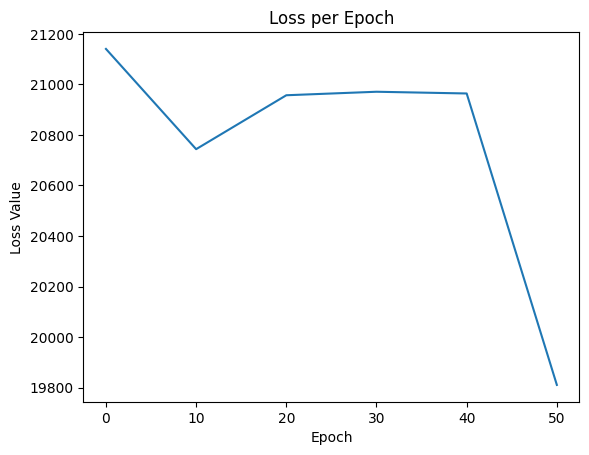

In [47]:
loss = norb_batch.loss

indices = list(range(len(loss)))

plt.plot([x * 10 for x in indices], loss)

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss per Epoch")

plt.show()

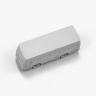

True label: truck
Guess:      truck


In [48]:
index = randint(0, norb_batch_train_x.size()[0])

# display the random image
im = Image.fromarray((norb_batch_test_x[index].numpy()*255).astype(np.uint8).reshape(96, 96))
display(im)

# print the label
true_label = torch.argmax(norb_batch_test_y[index])
print("True label:", norb_label_names[true_label])

# predict the label with the model
raw_guess = norb_batch.predict(torch.unsqueeze(norb_batch_test_x[index], 0))
sort_guess = torch.argsort(raw_guess, descending=True)[0] # sort the probabilities args
guess = sort_guess[0] # highest prob
second_guess = sort_guess[1] # second highest
print("Guess:     ", norb_label_names[guess])
if true_label != guess:
  print("Second guess:", norb_label_names[second_guess])

### Model 2: CNN

In [49]:
# Reshape data for model
norb_cnn_train_x, norb_cnn_train_y = tf_to_torch(norb_train, 5, False)
norb_cnn_test_x, norb_cnn_test_y = tf_to_torch(norb_test, 5, False)


norb_cnn_train_x = mmnormalize(norb_cnn_train_x)
norb_cnn_test_x = mmnormalize(norb_cnn_test_x)

In [50]:
# Create CNN model
norb_conv = model()

norb_conv.layers.append(convolution_layer(input_size=(96,96), kernel_size=(2,9,9)))
norb_conv.layers.append(max_pool(kernel_size=(4,4)))
norb_conv.layers.append(reduce_channel(channel_num=2, im_size=(22,22)))

norb_conv.layers.append(convolution_layer(input_size=(22,22), kernel_size=(2,7,7)))
norb_conv.layers.append(max_pool(kernel_size=(4,4)))
norb_conv.layers.append(reduce_channel(channel_num=2, im_size=(4,4)))


norb_conv.layers.append(tensor_contraction(tensor_size=(4,4,5), input_dim=2))
norb_conv.layers.append(rowwise_softmax())
norb_conv.cost = cross_entropy()


norb_conv.alpha = 0.01

In [51]:
# Set data and train
norb_conv.set_data(norb_cnn_train_x, norb_cnn_train_y)

if not norb_conv.load("norb2"):
  norb_conv.train(50, False, tx=norb_cnn_test_x, ty=norb_cnn_test_y, batch_size=10)
  norb_conv.save("norb2")

#set to 0 to skip additional training
cont = 50
if cont:
  print(f"continue training for {cont} epochs")
  norb_conv.train(cont, False, tx=norb_cnn_test_x, ty=norb_cnn_test_y, batch_size=10)
  norb_conv.save("norb2")

failed to load layer 0
started epoch 0 at time 00:00:00 with accuracy 0.2
started epoch 10 at time 00:00:08 with accuracy 0.6667
started epoch 20 at time 00:00:16 with accuracy 0.7396
started epoch 30 at time 00:00:24 with accuracy 0.7537
started epoch 40 at time 00:00:32 with accuracy 0.7902
continue training for 50 epochs
started epoch 0 at time 00:00:41 with accuracy 0.755
started epoch 10 at time 00:00:49 with accuracy 0.7828
started epoch 20 at time 00:00:56 with accuracy 0.7804
started epoch 30 at time 00:01:05 with accuracy 0.7898
started epoch 40 at time 00:01:13 with accuracy 0.7842


In [52]:
# Results
print("Accuracy: ", norb_conv.get_accuracy(norb_cnn_test_x, norb_cnn_test_y).item())
print()
print("Class specific Sensitivity and Precision: ")
print(print_acc(norb_conv.get_acc_metrics(norb_cnn_test_x, norb_cnn_test_y, [0, 1, 2, 3, 4]), ["four-legged animals", "human figures", "airplanes", "trucks", "cars"]))

Accuracy:  0.8007407188415527

Class specific Sensitivity and Precision: 
four-legged animals : 
  Sensitivity:  0.8207818930041152
  Precision:  0.7486861861861862
  Accuracy:  0.9090534979423869
human figures : 
  Sensitivity:  0.8380658436213991
  Precision:  0.8524487233151946
  Accuracy:  0.9386008230452675
airplanes : 
  Sensitivity:  0.7802469135802469
  Precision:  0.904364416885285
  Accuracy:  0.9395473251028806
trucks : 
  Sensitivity:  0.8296296296296296
  Precision:  0.7746397694524496
  Accuracy:  0.9176543209876543
cars : 
  Sensitivity:  0.7349794238683127
  Precision:  0.7447873227689742
  Accuracy:  0.8966255144032922

Average Sensitivity:  0.8007407407407406
Average Precision:  0.8049852837216178
Average Accuracy:  0.9202962962962964
None


### Model 2 Results:

Our "accuracy" seems to have finished around 75%. While this number isn't the greatest, according to surface level research, [above 70% is considered standard](https://www.fiddler.ai/model-accuracy-vs-model-performance/which-is-more-important-model-performance-or-model-accuracy#:~:text=Good%20accuracy%20in%20machine%20learning,demand%2099%25%20accuracy%20and%20up.) for image recognition, with state of the art models achieving over 95%.

CNN was incredibly sensitive to the hyper-parameters of its learning model. It took a quite a bit of fiddling around with different numbers and switching cost and transfer functions to finally reach this rate. Conclusion: Not bad but could be better.

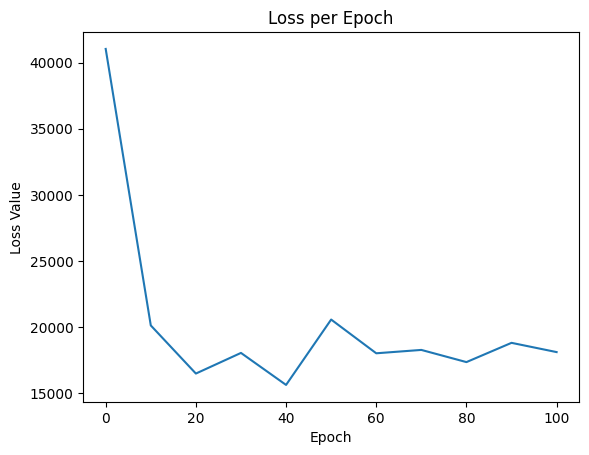

In [53]:
loss = norb_conv.loss
i = range(len(loss))

indices = list(range(len(loss)))

plt.plot([x * 10 for x in indices], loss)

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss per Epoch")

plt.show()

We can let the model predict the label for some image

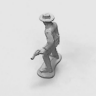

True label: human figure
Guess:      four-legged animal
Second guess: human figure


In [59]:
index = randint(0, norb_cnn_train_x.size()[0])

# display the random image
im = Image.fromarray((norb_cnn_test_x[index].numpy()*255).astype(np.uint8))
display(im)

# print the label
true_label = torch.argmax(norb_cnn_test_y[index])
print("True label:", norb_label_names[true_label])

# predict the label with the model
raw_guess = norb_conv.predict(torch.unsqueeze(norb_cnn_test_x[index], 0))
sort_guess = torch.argsort(raw_guess, descending=True)[0] # sort the probabilities args
guess = sort_guess[0] # highest prob
second_guess = sort_guess[1] # second highest
print("Guess:     ", norb_label_names[guess])
if true_label != guess:
  print("Second guess:", norb_label_names[second_guess])

# Conclusion

A majority of this project was an excuse to look at the math behind some of these AI models and to generally grasp the concepts more. It also gave us the opportunity to look at the PyTorch library, the usage of GPU, and familiarize ourselves more with Python. We also concluded that Neural Networks are very brittle and prone to explosion at no notice.
<br>
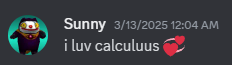